In [5]:
%load_ext autoreload
%autoreload 2

In [30]:
import tifffile as tiff
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay

import os
import sys
sys.path.append("/workspaces/codex-analysis/0-phenocycler-penntmc-pipeline")
from src.img_process.utility import *

In [48]:
# ---------------------
# config of the pipeline
# ---------------------
# Data info
data_dir = "/workspaces/codex-analysis/data/NW_Ovary_16/Scan1-test_sample/"
image_file = "NW_1_Scan1_test_sample.ome.tiff"
target_channel_names = ["DAPI", "CD45"]
# Crop images
crop_size = (1000, 1000)  # Crop size (height, width)
overlap = 200  # 200 pixels overlap

In [9]:
image_ndarray, tif_image_details = load_raw_image(data_dir, image_file, target_channel_names)
print(tif_image_details)

{'Data Type': dtype('uint8'), 'Shape': (1, 4000, 4000, 2), 'nucleus': 'DAPI', 'cell': 'CD45'}


In [32]:
cropped_images = crop_with_overlap(image_ndarray, crop_size, overlap)
cropped_rgb_image = create_rgb_image(cropped_images, channel_colors=['green', 'blue'])
print(f"Cropped images shape: {cropped_images.shape}")  # Expected shape: (B, 1000, 1000, 2)

Cropped images shape: (16, 1000, 1000, 2)


In [13]:
from deepcell.applications import Mesmer
from tensorflow.keras.models import load_model
file_name = "/workspaces/codex-analysis/data/deepcell/MultiplexSegmentation"
keras_model = load_model(file_name)
app = Mesmer(model=keras_model)
app.logger.setLevel('DEBUG')
segmentation_predictions_nuc = app.predict(cropped_images, image_mpp=0.5, compartment='nuclear')
print(f"Segmentation mask shape: {segmentation_predictions_nuc.shape}")  # Expected shape: (B, 1000, 1000, 1)

2024-09-16 23:49:33.932881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-16 23:49:33.933256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-16 23:49:33.939517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-16 23:49:33.939859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-16 23:49:33.940169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

DEBUG:Mesmer:Pre-processed data with mesmer_preprocess in 1.8480871804058552 s
2024-09-16 23:49:44.849741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
DEBUG:Mesmer:Model inference finished in 11.7044260436669 s
DEBUG:Mesmer:Post-processing results with mesmer_postprocess and kwargs: {'whole_cell_kwargs': {'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}, 'nuclear_kwargs': {'maxima_threshold': 0.1, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}, 'compartment': 'nuclear'}
DEBUG:Mesmer:Post-processed results with mesmer_postprocess in 13.91203427594155 s


In [33]:
overlay_data = make_outline_overlay(rgb_data=cropped_rgb_image, predictions=segmentation_predictions_nuc)

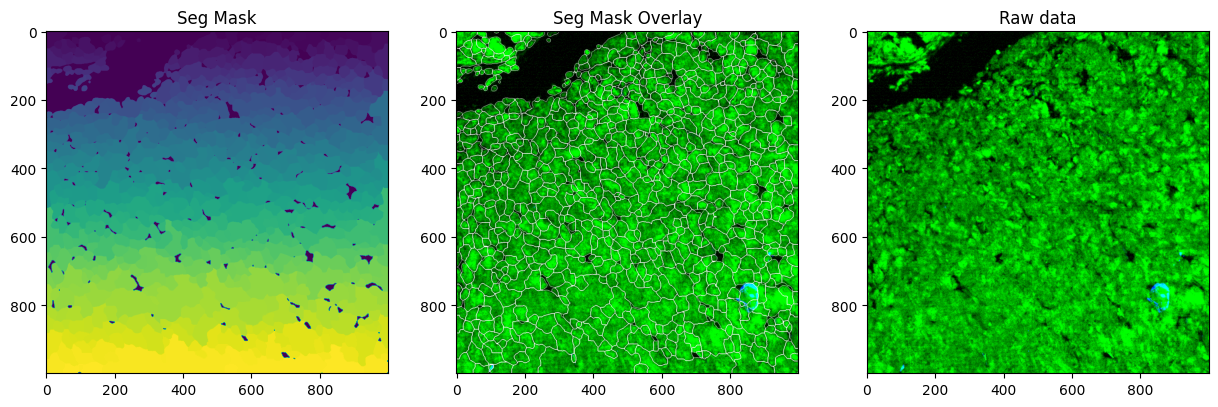

In [40]:
idx = 0

# plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(segmentation_predictions_nuc[idx])
ax[0].set_title('Seg Mask')

ax[1].imshow(overlay_data[idx])
ax[1].set_title('Seg Mask Overlay')

ax[2].imshow(cropped_rgb_image[idx])
ax[2].set_title('Raw data')
plt.show()

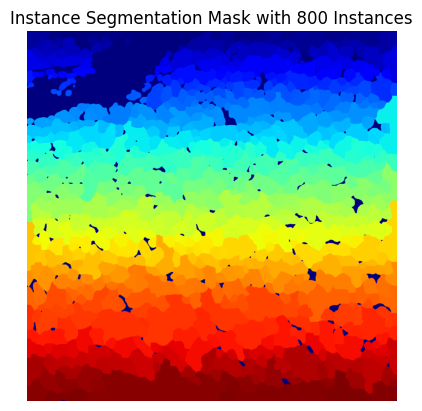

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def visualize_instance_segmentation(segmentation_mask):
    """
    Visualizes the instance segmentation mask where each instance ID is shown in a different color.
    
    Parameters:
    - segmentation_mask: numpy array of shape (H, W) where each value represents a different instance ID.
    """
    # Normalize the mask to fit into the range [0, 1] for better color mapping
    unique_instances = np.unique(segmentation_mask)
    norm = mcolors.Normalize(vmin=unique_instances.min(), vmax=unique_instances.max())

    # Create a color map with a distinct number of colors
    colormap = plt.colormaps.get_cmap('jet')
    color_list = colormap(np.linspace(0, 1, len(unique_instances)))  # Get a distinct color for each instance
    custom_cmap = mcolors.ListedColormap(color_list)

    # Apply the custom colormap to the normalized mask
    colored_mask = custom_cmap(norm(segmentation_mask))

    # Plot the colored instance segmentation mask
    plt.imshow(colored_mask)
    plt.axis('off')
    plt.title(f"Instance Segmentation Mask with {len(unique_instances)} Instances")
    plt.show()

# Assuming segmentation_predictions_nuc contains instance IDs (shape (B, H, W, 1))
instance_mask = segmentation_predictions_nuc[0, :, :, 0]  # First image, remove channel dim
visualize_instance_segmentation(instance_mask)

In [56]:
import numpy as np

class CVMaskStitcher():
    def __init__(self, overlap=80, threshold=8):
        self.overlap = overlap
        self.threshold = threshold

    def stitch_masks_horizontally(self, masks1, masks2):
        print(masks1.shape, masks2.shape)
        i, j1, N1 = masks1.shape
        _, j2, N2 = masks2.shape

        masks_overlap1 = masks1[:, -self.overlap:, :]
        masks_overlap2 = masks2[:, :self.overlap, :]
        print(masks_overlap1.shape, masks_overlap2.shape)
        pad_after_left = j2 - self.overlap
        pad_before_right = j1 - self.overlap

        plane_mask_1, plane_mask_2 = np.zeros(1), np.zeros(1)
        if N1 != 0:
            plane_mask_1 = np.max(np.arange(1, N1 + 1, dtype=np.uint16)[None, None, :] * masks_overlap1, axis=2).flatten()
        if N2 != 0:
            plane_mask_2 = np.max(np.arange(1, N2 + 1, dtype=np.uint16)[None, None, :] * masks_overlap2, axis=2).flatten()

        # Handle out-of-bounds indices by ensuring the values don't exceed the mask size
        plane_mask_1 = np.clip(plane_mask_1, 0, N1)
        plane_mask_2 = np.clip(plane_mask_2, 0, N2)

        if N1 != 0 and N2 != 0:
            M = np.zeros((N1 + 1, N2 + 1))
            np.add.at(M, (plane_mask_1, plane_mask_2), 1)

            del_indices_1 = []
            del_indices_2 = []

            for a in range(1, N1 + 1):
                for b in range(1, N2 + 1):
                    if M[a, b] > self.threshold:
                        if len(np.where(masks1[:, :, a - 1])[0]) > len(np.where(masks2[:, :, b - 1])[0]):
                            del_indices_2.append(b - 1)
                        else:
                            del_indices_1.append(a - 1)

            masks1 = masks1[:, :, list(set(np.arange(0, N1)) - set(del_indices_1))]
            masks2 = masks2[:, :, list(set(np.arange(0, N2)) - set(del_indices_2))]

        masks1 = np.pad(masks1, [(0, 0), (0, pad_after_left), (0, 0)], 'constant')
        masks2 = np.pad(masks2, [(0, 0), (pad_before_right, 0), (0, 0)], 'constant')

        return np.concatenate((masks1, masks2), axis=1)

    def stitch_masks_vertically(self, masks1, masks2):
        i1, j, N1 = masks1.shape
        i2, _, N2 = masks2.shape

        masks_overlap1 = masks1[-self.overlap:, :, :]
        masks_overlap2 = masks2[:self.overlap, :, :]

        pad_below_top = i2 - self.overlap
        pad_above_bottom = i1 - self.overlap

        plane_mask_1, plane_mask_2 = np.zeros(1), np.zeros(1)
        if N1 != 0:
            plane_mask_1 = np.max(np.arange(1, N1 + 1, dtype=np.uint16)[None, None, :] * masks_overlap1, axis=2).flatten()
        if N2 != 0:
            plane_mask_2 = np.max(np.arange(1, N2 + 1, dtype=np.uint16)[None, None, :] * masks_overlap2, axis=2).flatten()

        # Handle out-of-bounds indices
        plane_mask_1 = np.clip(plane_mask_1, 0, N1)
        plane_mask_2 = np.clip(plane_mask_2, 0, N2)

        if N1 != 0 and N2 != 0:
            M = np.zeros((N1 + 1, N2 + 1))
            np.add.at(M, (plane_mask_1, plane_mask_2), 1)

            del_indices_1 = []
            del_indices_2 = []

            for a in range(1, N1 + 1):
                for b in range(1, N2 + 1):
                    if M[a, b] > self.threshold:
                        if len(np.where(masks1[:, :, a - 1])[0]) > len(np.where(masks2[:, :, b - 1])[0]):
                            del_indices_2.append(b - 1)
                        else:
                            del_indices_1.append(a - 1)

            masks1 = masks1[:, :, list(set(np.arange(0, N1)) - set(del_indices_1))]
            masks2 = masks2[:, :, list(set(np.arange(0, N2)) - set(del_indices_2))]

        masks1 = np.pad(masks1, [(0, pad_below_top), (0, 0), (0, 0)], 'constant')
        masks2 = np.pad(masks2, [(pad_above_bottom, 0), (0, 0), (0, 0)], 'constant')

        return np.concatenate((masks1, masks2), axis=0)

    def stitch_masks(self, masks, nrows, ncols):
        assert(len(masks) == nrows * ncols)
        
        horizontal_strips = []
        
        # Create horizontal strips
        for i in range(0, len(masks), ncols):
            strip = masks[i]
            
            for a in range(i + 1, i + ncols):
                strip = self.stitch_masks_horizontally(strip, masks[a])
            horizontal_strips.append(strip)
        
        # Stitch horizontal strips
        full_mask = horizontal_strips[0]
        for j in range(1, nrows):
            full_mask = self.stitch_masks_vertically(full_mask, horizontal_strips[j])
        
        return full_mask


In [69]:
def expand_to_n_channel(mask):
    """
    Expands a single-channel instance mask into an N-channel binary mask.
    
    Parameters:
    - mask: (H, W, 1) array where each pixel represents an instance ID.
    
    Returns:
    - Expanded (H, W, N) mask where N is the number of unique instances, and each channel is a binary mask for one instance.
    """
    mask = np.squeeze(mask)
    unique_instances = np.unique(mask)
    unique_instances = unique_instances[unique_instances != 0]  # Ignore background (assumed to be 0)
    n_channels = len(unique_instances)

    expanded_mask = np.zeros((mask.shape[0], mask.shape[1], n_channels), dtype=np.uint8)

    for i, instance_id in enumerate(unique_instances):
        expanded_mask[:, :, i] = (mask == instance_id).astype(np.uint8)

    return expanded_mask

expand_to_n_channel(cropped_masks[0]).shape

(1000, 1000, 799)

In [58]:
# Example usage
cropped_masks = segmentation_predictions_nuc  # Assuming the cropped masks from earlier
# Calculate the number of rows and columns based on the original image size and crop size
original_image_shape = (4000, 4000)  # Example original image size
nrows = (original_image_shape[0] - crop_size[0]) // (crop_size[0] - overlap) + 1
ncols = (original_image_shape[1] - crop_size[1]) // (crop_size[1] - overlap) + 1
print(f"Number of rows: {nrows}, Number of columns: {ncols}")

# Initialize the CVMaskStitcher with your overlap value
stitcher = CVMaskStitcher(overlap=overlap, threshold=8)

# Stitch the cropped masks
stitched_mask = stitcher.stitch_masks(cropped_masks, nrows, ncols)

# Visualize the stitched mask
plt.imshow(stitched_mask[:, :, 0], cmap='gray')
plt.axis('off')
plt.title("Stitched Mask")
plt.show()

Number of rows: 4, Number of columns: 4
(1000, 1000, 1) (1000, 1000, 1)
(1000, 200, 1) (1000, 200, 1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 0 and the array at index 1 has size 1

In [ ]:
∫